https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [1]:
import pandas as pd
import numpy as np

from sklearn import linear_model, datasets, metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set(rc={"figure.figsize": (8, 4)})

### Data loading

In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

df_test_id_series = df_test['Id']

### Data cleaning and preparation

#### Helper functions

In [4]:
def missing_data_total_percent(df):
    missing_total = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum() / df.shape[0]).sort_values(ascending=False)
    return (missing_total, missing_percent)

#### Drop some columns with too much missing data

In [5]:
missing_total, missing_percent = missing_data_total_percent(df_train)

columns_with_too_much_missing_data = missing_percent[missing_percent > 0.9].index.values
print("Columns with too much missing data: {}".format(columns_with_too_much_missing_data))

# we should not consider 'Id' as a feature
columns_to_remove = np.append(columns_with_too_much_missing_data, ['Id'])
print("Columns to remove: {}".format(columns_to_remove))

df_train = df_train.drop(columns_to_remove, axis='columns')
df_test = df_test.drop(columns_to_remove, axis='columns')

Columns with too much missing data: ['PoolQC' 'MiscFeature' 'Alley']
Columns to remove: ['PoolQC' 'MiscFeature' 'Alley' 'Id']


#### Fill missing data for numerical features, where mean/median doesn't make sense 

In [6]:
num_features_fill_na_0 = ['LotFrontage', 'MasVnrArea', 'BsmtHalfBath', 'BsmtFullBath',
                          'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GarageCars']

df_train[num_features_fill_na_0] = df_train[num_features_fill_na_0].fillna(0)
df_test[num_features_fill_na_0] = df_test[num_features_fill_na_0].fillna(0)

#### Categorical encoding for some numerical features

In [7]:
month_num_to_name_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May',
                          6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df_train['MoSold'] = df_train['MoSold'].map(month_num_to_name_dict)
df_test['MoSold'] = df_test['MoSold'].map(month_num_to_name_dict)

ms_subclass_num_cat_dict = {20: 'ms_subclass_20', 30: 'ms_subclass_30',
                            40: 'ms_subclass_40', 45: 'ms_subclass_45', 50: 'ms_subclass_50',
                            60: 'ms_subclass_60', 70: 'ms_subclass_70', 75: 'ms_subclass_75',
                            80: 'ms_subclass_80', 85: 'ms_subclass_85', 90: 'ms_subclass_90',
                            120: 'ms_subclass_120', 150: 'ms_subclass_150', 160: 'ms_subclass_160',
                            180: 'ms_subclass_180', 190: 'ms_subclass_190'}

df_train['MSSubClass'] = df_train['MSSubClass'].map(ms_subclass_num_cat_dict)
df_test['MSSubClass'] = df_test['MSSubClass'].map(ms_subclass_num_cat_dict)

Преобразование признака MoSold в категориальный улучшил результат на тестовой выборке на 0.0002, немного. MSSubClass: улучшило примерно на 0.00036

#### Log transformation: features

Признак 'GrLivArea':


Удаление выброса сильно улучшает результат на CV, но несколько ухудшает его на test set. В чем дело? Скорее всего в тестовой выборке тоже outlier с большим значением GrLivArea и аномально маленькой ценой.

Видимо, вот он: id=2550

Можно искусственно уменьшить предсказываемый sale price для этого объекта в test set, но это нечестно. Хотя это и должно заметно улучшить оценку на test set. См. https://www.kaggle.com/c/house-prices-advanced-regression-techniques/discussion/210174

Попробуем применить какую-нибудь трансформацию для этого признака (логарифм?), чтобы уменьшить влияние этих выбросов.

Скорее всего, по этой причине, без удаления выбросов, у нас получались странные результаты на отложенной (hold-out) выборке.

Лог-трансформация (log scaling) признака GrLivArea убрала положительное смещение (skewness) в распределении этого признака. 1.367 -> -6.00e-3. См. ноутбук по EDA.

Info: https://medium.com/analytics-vidhya/log-transform-for-positivity-d3e1f183c804

"Log transform reduces or removes skewness and tries to make our distribution normal." "It is common practice to apply a logarithmic transformation on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm."

Лог-трансформация признака GrLivArea сильно улучшила результат на тестовой выборке: с 0.13206 до 0.12621.

Попробовал другие способы убрать перекос:

RobustScaler показал в результате практически то же самое, что и простой StandardScaler. В свою очередь PowerTransformer (метод Бокса-Кокса) по результатам был очень похож уже на лог-преобразование.

Наибольший прирост был на тех числовых признаках, где на диаграмме рассеяним с SalePrice были заметны отклонения в виде выбросов. Признаки: 'GrLivArea', 'LotArea', 'BsmtSF...', 'MasVnrArea', '1stFlrSF'

In [8]:
features_log_transform = ['GrLivArea', 'LotArea', 'BsmtFinSF1', 'BsmtFinSF2',
                          'BsmtUnfSF', 'TotalBsmtSF', 'MasVnrArea', '1stFlrSF',
                          'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch']

df_train[features_log_transform] = np.log1p(df_train[features_log_transform])
df_test[features_log_transform] = np.log1p(df_test[features_log_transform])

#### Log transformation: target variable

Skewness: 1.8828757597682129


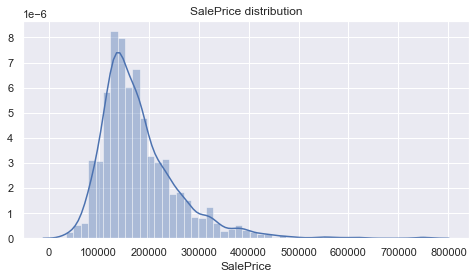

In [9]:
ax = sns.distplot(df_train['SalePrice'])
ax.set_title('SalePrice distribution')
print("Skewness: {}".format(df_train['SalePrice'].skew()))

##### Обоснование лог-трансформации SalePrice

Думаю, основная причина заключается в той метрике, которая используется для оценки тестовой выборки. А именно: RMSLE.
Мотивация ее использования:
"Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally."

То есть, например, log(800.000) - log(700.000) < log(200.000) - log(100.000), хотя разность аргументов одинакова.
То есть для такой оценки важнее доля (прирост), а не абсолютная разность.

Если лог-трансформация для SalePrice не применяется, то т.к. при обучении модели используются обычные MSE или MAE-оценки, то особенность, заложенная в логарифмической оценке, не будет учитываться, а следовательно, дорогие и дешевые дома будут оцениваться по-разному.

Помимо этого, на графике распределения SalePrice мы наблюдаем некоторое смещение в сторону очень дорогих домов, которые оказывают значительное влияние на результат.

По этой теме см. также обсуждение:
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/discussion/103975

In [10]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])

Log-transformation of SalePrice has significantly improved my score on test test:
from 0.13853 to 0.13208

#### Preprocessing pipeline

StandardScaler:

If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

In [11]:
num_preprocess_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                                    ('scaler', StandardScaler())])

cat_preprocess_ohe_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='<missing>')),
                                        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))])

column_type_based_preprocess_ohe_transformer = ColumnTransformer([
    ('numerical', num_preprocess_pipeline,
     make_column_selector(dtype_include='number')),
    ('categorical', cat_preprocess_ohe_pipeline,
     make_column_selector(dtype_include='object'))
])

preprocessing_ohe_pipeline = Pipeline(
    [('column_based_preprocess_pipeline', column_type_based_preprocess_ohe_transformer)])

### Create datasets for training: X, y

In [12]:
X_train = df_train.copy()
y_train = X_train.pop('SalePrice')

#### Train-test split

In [13]:
# При данном random_state и test_size 2 объекта-выброса попадают в разные выборки: одна -- в train, другая -- в hold-out.

X_train_part, X_hold_out, y_train_part, y_hold_out = train_test_split(
    X_train, y_train, test_size=0.15, random_state=28)

### Models

#### Helper functions

In [14]:
def print_grid_search_cv_result(grid_cv, hyperparam_values=None):
    print("Best score:", -grid_cv.best_score_)
    print("Best alpha:", grid_cv.best_params_)
    cv_mean_test_scores = -grid_cv.cv_results_['mean_test_score']
    if (hyperparam_values is not None):
        print("\n Hyperparameter value to CV mean test score:")
        print(pd.Series(cv_mean_test_scores, index=hyperparam_values))
    else:
        print("CV mean test scores:")
        print(cv_mean_test_scores)

In [15]:
def build_validation_curve(estimator, X_train, y_train, param_name, param_range, x_label, ylim):
    train_scores, test_scores = validation_curve(estimator, X_train, y_train, \
                                                param_name=param_name, param_range=param_range, \
                                                cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    train_scores = np.negative(train_scores)
    test_scores = np.negative(test_scores)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    print("Cross-validation scores:")
    print(test_scores_mean)
    
    plt.figure(figsize=(12, 8))
    plt.title("Validation Curve for " + x_label)
    plt.xlabel(x_label)
    plt.ylabel("Error (RMSE)")
    plt.ylim(ylim[0], ylim[1])
    
    plt.plot(param_range, train_scores_mean, color='orange', label="Training error")
    plt.grid()
    plt.fill_between(param_range, \
                 train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='orange')
    plt.plot(param_range, test_scores_mean, color='blue', label="Cross-validation error")
    plt.fill_between(param_range, \
                 test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color='blue')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

### LASSO Regression Model

Docs:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html

https://scikit-learn.org/stable/modules/linear_model.html#lasso

In [16]:
from sklearn.linear_model import Lasso

In [125]:
lasso_model = Lasso(max_iter=10000, selection='random', random_state=19)
lasso_pipeline = Pipeline([('preprocessing', preprocessing_ohe_pipeline), ('model', lasso_model)])

In [57]:
# lasso_alphas = np.logspace(-4, -3, 20)
# print(lasso_alphas)

In [126]:
lasso_alphas = [0.0002, 0.00025, 0.0003, 0.00035, 0.0004, 0.00045,
                0.0005, 0.00053, 0.00054, 0.00055, 0.00058, 0.0006, 0.00065, 0.0007]

# lasso_pipeline.get_params()
lasso_parameters_grid = {'model__alpha': lasso_alphas}

lasso_grid_cv = GridSearchCV(lasso_pipeline, lasso_parameters_grid, 
                             scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)

In [127]:
%%time
lasso_grid_cv.fit(X_train, y_train)

Wall time: 28.9 s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('column_based_preprocess_pipeline',
                                                         ColumnTransformer(transformers=[('numerical',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer()),
                                                                                                          ('scaler',
                                                                                                           StandardScaler())]),
                                                                                          <sklearn.compose._column_transformer.make_column_selector object at 0x0000023E8D847FA0>),
                                                           

In [128]:
print_grid_search_cv_result(lasso_grid_cv, lasso_alphas)

Best score: 0.12049463997315266
Best alpha: {'model__alpha': 0.00045}

 Alpha to CV mean test score:
0.00020    0.122383
0.00025    0.121453
0.00030    0.120858
0.00035    0.120599
0.00040    0.120505
0.00045    0.120495
0.00050    0.120512
0.00053    0.120502
0.00054    0.120504
0.00055    0.120505
0.00058    0.120524
0.00060    0.120544
0.00065    0.120631
0.00070    0.120774
dtype: float64


Замечание! Для alpha=0.00055 на тестовых данных результат получается лучше где-то на 0.0003, чем для найденного в рамках CV при количестве фолдов=10 значения alpha=0.00045. Возможно, связано с тем, что распределение тренировочной и тестовой выборов несколько отличаются.. Или, возможно, эффект случайности: разбиения не слишком хорошо отражают истинное распределение, еще стоит учитывать выбросы, которые не удалялись. Как вариант, можно изменить random_state.
В следующей ячейке фиксирую лучшую модель LASSO с alpha=0.00055

Попробовал random_state=23; 51 – результат тот же.

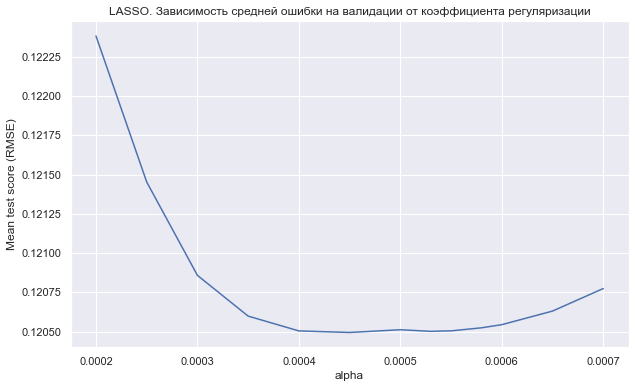

In [143]:
lasso_cv_mean_test_scores = lasso_grid_cv.cv_results_['mean_test_score']

plt.figure(figsize=(10, 6))
plt.plot(lasso_alphas, -lasso_cv_mean_test_scores)
plt.xlabel('alpha')
plt.ylabel('Mean test score (RMSE)')
plt.title('LASSO. Зависимость средней ошибки на валидации от коэффициента регуляризации');
plt.show()

#### Lasso best estimator

In [17]:
###### LASSO best estimator #####
# Considering the comments above, we take alpha=0.00055 for the best estimator:

lasso_model = Lasso(max_iter=10000, selection='random', random_state=19, alpha=0.00055)
lasso_best_estimator = Pipeline(
    [('preprocessing', preprocessing_ohe_pipeline), ('model', lasso_model)])

lasso_best_estimator.fit(X_train, y_train);
######

In [137]:
lasso_predicted_y = lasso_best_estimator.predict(X_train)
print('Some predictions on the training set:')
print(np.exp(lasso_predicted_y[:5]))

error = mean_squared_error(y_train, lasso_predicted_y, squared=False)
print("LassoCV best estimator. Error on the whole training set: {}".format(error))

Some predictions on the training set:
[203966.6496486  192084.55493118 217270.30168072 174835.66330535
 296453.26609878]
LassoCV best estimator. Error on the whole training set: 0.10503512684363614


#### #Experiments: train Lasso on a part of the training set and evaluate it on the hold-out set

In [132]:
lasso_part_grid_cv = GridSearchCV(lasso_pipeline, lasso_parameters_grid, 
                             scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
lasso_part_grid_cv.fit(X_train_part, y_train_part);

In [133]:
print("Split dataset \n")
print_grid_search_cv_result(lasso_part_grid_cv, lasso_alphas)

Split dataset 

Best score: 0.11584134924800589
Best alpha: {'model__alpha': 0.00045}

 Alpha to CV mean test score:
0.00020    0.116981
0.00025    0.116525
0.00030    0.116226
0.00035    0.115971
0.00040    0.115843
0.00045    0.115841
0.00050    0.115947
0.00053    0.115996
0.00054    0.116008
0.00055    0.116020
0.00058    0.116073
0.00060    0.116116
0.00065    0.116227
0.00070    0.116310
dtype: float64


In [134]:
lasso_train_part_best_estimator = lasso_part_grid_cv.best_estimator_
lasso_hold_out_predicted_y = lasso_train_part_best_estimator.predict(X_hold_out)
error = mean_squared_error(y_hold_out, lasso_hold_out_predicted_y, squared=False)
print("LassoCV. Error on the hold-out set: {}".format(error))

LassoCV. Error on the hold-out set: 0.16286343167093523


#### Lasso trained estimator analysis

In [91]:
lasso_best_estimator_coefs = lasso_best_estimator.named_steps['model'].coef_

print('Lasso. Picked features count:', sum(lasso_best_estimator_coefs != 0))
print('Lasso. Eliminated features count:', sum(lasso_best_estimator_coefs == 0))

Lasso. Picked features count: 111
Lasso. Eliminated features count: 206


In [83]:
# get feature names

column_based_pipeline = \
    lasso_best_estimator.named_steps['preprocessing'].named_steps['column_based_preprocess_pipeline']

numeric_feature_names = np.array(column_based_pipeline.transformers_[0][2])
cat_feature_names = \
    np.array(column_based_pipeline.transformers_[1][1].named_steps['one_hot_encoder'].get_feature_names())

feature_names = np.concatenate([numeric_feature_names, cat_feature_names])
len(feature_names)

317

In [92]:
print('Lasso feature coefficients.\n')
lasso_feature_coefs = pd.Series(lasso_best_estimator_coefs, index=feature_names)
print('Head:')
print(lasso_feature_coefs.sort_values(ascending=False).head(30))
print('\nTail:')
print(lasso_feature_coefs.sort_values(ascending=False).tail(20))

Lasso feature coefficients.

Head:
x8_StoneBr           0.101678
x8_Crawfor           0.100571
GrLivArea            0.092133
x8_NridgHt           0.073526
x31_Typ              0.073150
OverallQual          0.071394
x8_NoRidge           0.069473
x15_BrkFace          0.065872
x30_Ex               0.060918
x8_Somerst           0.051904
YearBuilt            0.051462
x9_Norm              0.051043
x21_Ex               0.050694
1stFlrSF             0.049951
OverallCond          0.046306
x8_BrkSide           0.041355
x23_Gd               0.041007
LotArea              0.036748
2ndFlrSF             0.036734
GarageCars           0.034932
x27_Ex               0.027142
BsmtFinSF1           0.025977
x6_CulDSac           0.024024
x0_ms_subclass_20    0.022406
x19_TA               0.020236
x20_PConc            0.019995
x40_New              0.019635
TotalBsmtSF          0.019619
x8_ClearCr           0.016410
BsmtFullBath         0.015802
dtype: float64

Tail:
x6_FR2               -0.011083
x18_TA      

#### Residuals

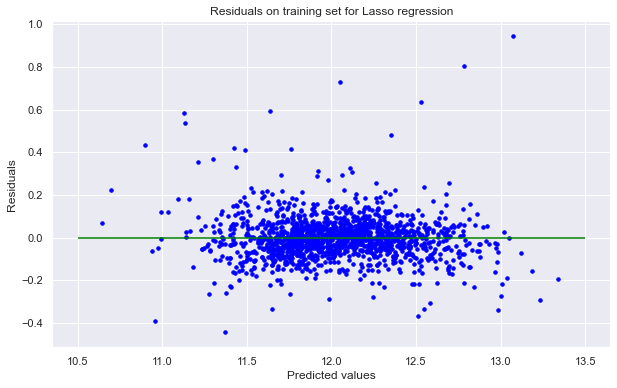

In [185]:
plt.figure(figsize=(10, 6))
plt.scatter(lasso_predicted_y, lasso_predicted_y - y_train, c="blue", s=12)
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "green")
plt.title("Residuals on training set for Lasso regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

**LASSO model best score on test set: 0.12351**

### XGBoost Regressor

Docs:
https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

https://habr.com/ru/company/ods/blog/327250/

https://scikit-learn.org/stable/modules/ensemble.html#ensemble

In [18]:
from xgboost import XGBRegressor

#### Validation curves

Cross-validation scores:
[1.96050336 0.3722698  0.14447392 0.14204231 0.14220487 0.14211061
 0.14214943 0.14214724 0.14214724]


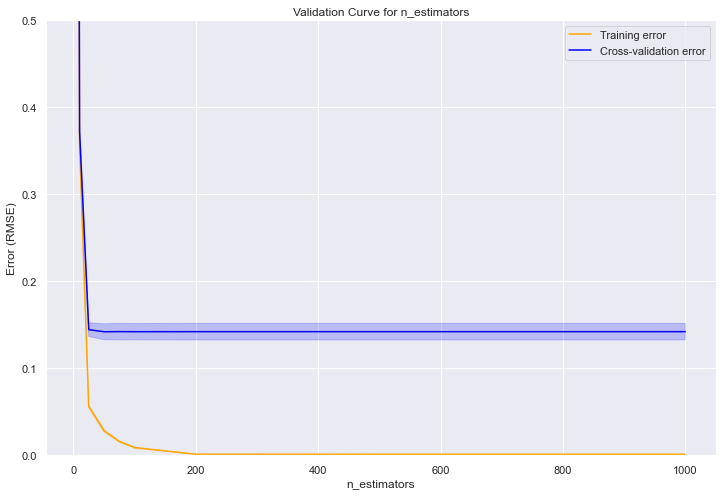

In [35]:
xgb_n_estimators = [5, 10, 25, 50, 75, 100, 200, 500, 1000]

xgb_model = XGBRegressor(random_state=19)
xgb_pipeline = Pipeline([('preprocessing', preprocessing_ohe_pipeline), ('model', xgb_model)])

build_validation_curve(xgb_pipeline, X_train, y_train, "model__n_estimators",
                       xgb_n_estimators, "n_estimators", (0, 0.5))

Cross-validation scores:
[0.13798806 0.1310132  0.12907948 0.13422533 0.13805745 0.14184456
 0.14800744 0.14672881 0.14648081]


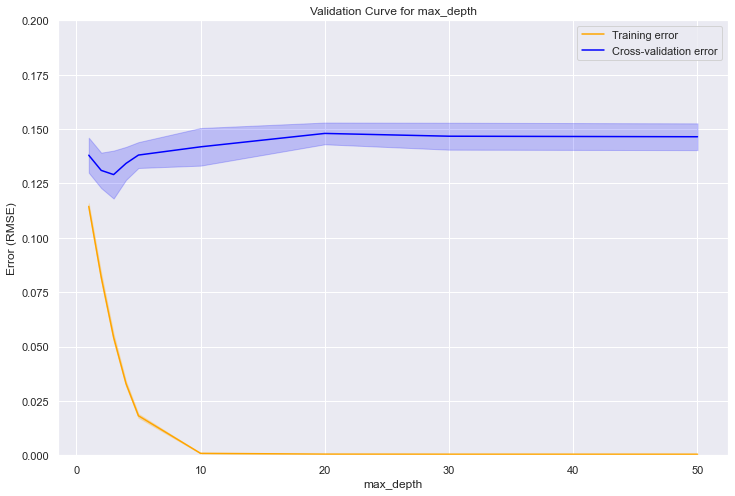

In [36]:
xgb_max_depth_range = [1, 2, 3, 4, 5, 10, 20, 30, 50]

xgb_model = XGBRegressor(random_state=19, n_estimators=100)
xgb_pipeline = Pipeline([('preprocessing', preprocessing_ohe_pipeline), ('model', xgb_model)])

build_validation_curve(xgb_pipeline, X_train, y_train, "model__max_depth",
                       xgb_max_depth_range, "max_depth", (0, 0.2))

In [30]:
xgb_learning_rate_range = np.logspace(-2, 0, 20)
xgb_learning_rate_range

array([0.01      , 0.01274275, 0.01623777, 0.02069138, 0.02636651,
       0.03359818, 0.04281332, 0.05455595, 0.06951928, 0.08858668,
       0.11288379, 0.14384499, 0.18329807, 0.23357215, 0.29763514,
       0.37926902, 0.48329302, 0.61584821, 0.78475997, 1.        ])

Cross-validation scores:
[4.2357711  3.2152138  2.26221221 1.44647383 0.82280289 0.41577699
 0.21054688 0.14815757 0.13779713 0.13249865 0.13170992 0.12873819
 0.13004926 0.13082737 0.13214159 0.13693745 0.13995795 0.14485974
 0.15976777 0.18582821]


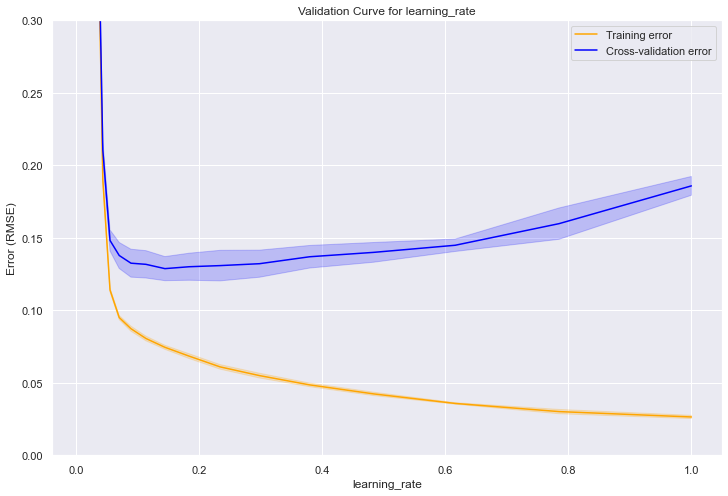

In [37]:
xgb_model = XGBRegressor(random_state=19, n_estimators=100, max_depth=3)
xgb_pipeline = Pipeline([('preprocessing', preprocessing_ohe_pipeline), ('model', xgb_model)])

build_validation_curve(xgb_pipeline, X_train, y_train, "model__learning_rate",
                       xgb_learning_rate_range, "learning_rate", (0, 0.3))

#### Hyperparameters search: max_depth and learning_rate

In [38]:
xgb_max_depth_range = [1, 2, 3, 4, 5, 10, 20, 30, 50]
xgb_learning_rate_range = np.logspace(-2, 0, 20)

In [30]:
xgb_model = XGBRegressor(random_state=19, n_estimators=50)
xgb_pipeline = Pipeline([('preprocessing', preprocessing_ohe_pipeline), ('model', xgb_model)])

xgb_parameters_grid = {'model__max_depth': xgb_max_depth_range, 'model__learning_rate': xgb_learning_rate_range}
xgb_grid_cv = GridSearchCV(xgb_pipeline, xgb_parameters_grid, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)

xgb_grid_cv.fit(X_train, y_train);

In [40]:
print("XGBoost CV. max_depth and learning_rate \n")
print_grid_search_cv_result(xgb_grid_cv, xgb_max_depth_range)

XGBoost CV. max_depth and learning_rate 

Best score: 0.13273673435485317
Best alpha: {'model__learning_rate': 0.24, 'model__max_depth': 3}
[0.16030843 0.14275791 0.13754556 0.13554936 0.13625759 0.13800036
 0.1368541  0.13693223 0.13699234 0.15852506 0.14090224 0.13739442
 0.13531026 0.13645675 0.13811173 0.13960131 0.1384821  0.13833048
 0.15752885 0.1407108  0.1371704  0.13640717 0.13720467 0.13798703
 0.13917985 0.13968629 0.14004045 0.15583664 0.14156733 0.13675999
 0.13684246 0.13676553 0.1357917  0.137371   0.13786024 0.137661
 0.15477163 0.13978893 0.13359776 0.13302523 0.13417816 0.13497372
 0.13823922 0.1378215  0.13759241 0.15287394 0.13877927 0.13623522
 0.13629709 0.13702146 0.13852429 0.13842556 0.137284   0.13741096
 0.15321085 0.13922354 0.13435812 0.1362877  0.13355825 0.14195253
 0.14043053 0.14231222 0.14179271 0.15214154 0.13662981 0.13474953
 0.13632271 0.1373661  0.14114917 0.14314403 0.14251095 0.14248339
 0.15068842 0.1370246  0.13554716 0.13461578 0.13436122 0.

In [20]:
xgb_max_depth_range = [1, 2, 3, 4, 5, 10, 20, 30]
xgb_learning_rate_range = [0.15, 0.17, 0.19, 0.21, 0.23, 0.25, 0.27, 0.29, 0.31]

xgb_model = XGBRegressor(random_state=19, n_estimators=100)
xgb_pipeline = Pipeline([('preprocessing', preprocessing_ohe_pipeline), ('model', xgb_model)])

xgb_parameters_grid = {'model__max_depth': xgb_max_depth_range, 'model__learning_rate': xgb_learning_rate_range}
xgb_grid_cv = GridSearchCV(xgb_pipeline, xgb_parameters_grid, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)

xgb_grid_cv.fit(X_train, y_train);

In [24]:
print("XGBoost CV. max_depth and learning_rate, detailed \n")
print_grid_search_cv_result(xgb_grid_cv)

XGBoost CV. max_depth and learning_rate, detailed 

Best score: 0.12874541155138397
Best alpha: {'model__learning_rate': 0.25, 'model__max_depth': 2}
CV mean test scores:
[0.14213666 0.13130641 0.12977198 0.13082519 0.13347054 0.1365503
 0.1358289  0.13604049 0.14187623 0.13019184 0.13097221 0.13192952
 0.13459748 0.13713617 0.13884215 0.13929338 0.14091984 0.13130619
 0.12937068 0.12973218 0.13244004 0.13444363 0.13802941 0.13766937
 0.13980371 0.13066204 0.13044027 0.13400206 0.131923   0.14173373
 0.14037931 0.142259   0.13783848 0.13093534 0.13152021 0.13239914
 0.13229134 0.13922799 0.14117366 0.14139346 0.13552369 0.12874541
 0.13333033 0.13302257 0.13467233 0.14180911 0.14261023 0.14366336
 0.13751003 0.12892442 0.13336759 0.13251113 0.13407533 0.13989084
 0.14315635 0.14406063 0.13684329 0.13033179 0.12901266 0.13569804
 0.13553626 0.13996088 0.14312195 0.14314896 0.13740333 0.12890079
 0.13188859 0.1355425  0.13525811 0.142119   0.14406639 0.14446963]


Note: It looks like that by minimizing "max_depth" one should increase "n_estimators"

#### Best estimator

In [19]:
### best estimator
xgb_model = XGBRegressor(random_state=19, n_estimators=100, max_depth=2, learning_rate=0.25)
xgb_best_estimator = Pipeline([('preprocessing', preprocessing_ohe_pipeline), ('model', xgb_model)])

xgb_best_estimator.fit(X_train, y_train);
###

In [56]:
xgb_predicted_y = xgb_best_estimator.predict(X_train)
print('Some predictions on the training set:')
print(np.exp(xgb_predicted_y[:5]))

error = mean_squared_error(y_train, xgb_predicted_y, squared=False)
print("XGB best estimator. Error on the whole training set: {}".format(error))

Some predictions on the training set:
[205190.33 171707.69 206005.2  159153.27 307794.6 ]
XGB best estimator. Error on the whole training set: 0.08912784477498188


#### Baseline estimator

In [20]:
### baseline estimator
xgb_model = XGBRegressor(random_state=19, n_estimators=100)
xgb_baseline_estimator = Pipeline([('preprocessing', preprocessing_ohe_pipeline), ('model', xgb_model)])

xgb_baseline_estimator.fit(X_train, y_train);
###

#### testing with the hold-out set

In [46]:
xgb_model = XGBRegressor(random_state=19, n_estimators=100, max_depth=2, learning_rate=0.25)
xgb_part_best_estimator = Pipeline([('preprocessing', preprocessing_ohe_pipeline), ('model', xgb_model)])

xgb_part_best_estimator.fit(X_train_part, y_train_part);

In [49]:
xgb_predicted_y = xgb_part_best_estimator.predict(X_train_part)
error = mean_squared_error(y_train_part, xgb_predicted_y, squared=False)
print("XGBRegressor. Split dataset. Error on the split training set: {}".format(error))

XGBRegressor. Split dataset. Error on the split training set: 0.08911736240181777


In [50]:
xgb_predicted_y_hold_out = xgb_part_best_estimator.predict(X_hold_out)
error = mean_squared_error(y_hold_out, xgb_predicted_y_hold_out, squared=False)
print("XGBRegressor. Split dataset. Error on the hold-out set: {}".format(error))

XGBRegressor. Split dataset. Error on the hold-out set: 0.13386355099806355


**XGBoost scores:**

baseline model(n_estimators=100): 0.14155

tuned model(n_estimators=100, max_depth=2, learning_rate=0.25): 0.13520

### Ensembling. StackingRegressor

Docs:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html

https://scikit-learn.org/stable/modules/ensemble.html#stacking

https://dyakonov.org/2017/03/10/c%D1%82%D0%B5%D0%BA%D0%B8%D0%BD%D0%B3-stacking-%D0%B8-%D0%B1%D0%BB%D0%B5%D0%BD%D0%B4%D0%B8%D0%BD%D0%B3-blending/

In [21]:
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor

In [26]:
estimators_xgb_baseline = [('lasso', lasso_best_estimator), ('xgboost', xgb_baseline_estimator)]
estimators_xgb_tuned = [('lasso', lasso_best_estimator), ('xgboost', xgb_best_estimator)]

final_estimator_alphas = (0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
final_estimator = RidgeCV(alphas=final_estimator_alphas, scoring='neg_root_mean_squared_error')
lasso_xgb_stacking = StackingRegressor(estimators=estimators_xgb_baseline, final_estimator=final_estimator)

In [27]:
# train on the split dataset
lasso_xgb_stacking.fit(X_train_part, y_train_part);

In [28]:
print('Lasso-XGBoost stacking CV. Split dataset.\n')

print("Coefficients: ", lasso_xgb_stacking.final_estimator_.coef_)
print("Estimated alpha: ", lasso_xgb_stacking.final_estimator_.alpha_)
print("Best score: ", -lasso_xgb_stacking.final_estimator_.best_score_)

lasso_xgb_stacking_predicted_y_hold_out = lasso_xgb_stacking.predict(X_hold_out)
error = mean_squared_error(y_hold_out, lasso_xgb_stacking_predicted_y_hold_out, squared=False)
print("Error on the hold-out set: ", error)

Lasso-XGBoost stacking CV. Split dataset.

Coefficients:  [0.85017639 0.14933152]
Estimated alpha:  0.1
Best score:  0.11629558367717638
Error on the hold-out set:  0.1469093791003197


In [31]:
# train with the tuned xgb estimator

lasso_xgb_stacking_xgb_tuned = StackingRegressor(estimators=estimators_xgb_tuned, final_estimator=final_estimator)
lasso_xgb_stacking_xgb_tuned.fit(X_train_part, y_train_part);

print('Lasso-XGBoost stacking CV with the best XGB estimator. Split dataset.\n')

print("Coefficients: ", lasso_xgb_stacking_xgb_tuned.final_estimator_.coef_)
print("Estimated alpha: ", lasso_xgb_stacking_xgb_tuned.final_estimator_.alpha_)
print("Best score: ", -lasso_xgb_stacking_xgb_tuned.final_estimator_.best_score_)

lasso_xgb_stacking_predicted_y_hold_out = lasso_xgb_stacking_xgb_tuned.predict(X_hold_out)
error = mean_squared_error(y_hold_out, lasso_xgb_stacking_predicted_y_hold_out, squared=False)
print("Error on the hold-out set: ", error)

Lasso-XGBoost stacking CV with the best XGB estimator. Split dataset.

Coefficients:  [0.83032304 0.16992507]
Estimated alpha:  0.1
Best score:  0.11649933093928161
Error on the hold-out set:  0.15014102604084464


The tuned model is worse than the baseline one on the hold-out set.

In [113]:
# train on the full training dataset
lasso_xgb_stacking.fit(X_train, y_train);

In [114]:
print('Lasso-XGBoost stacking CV. Full dataset.\n')

print("Coefficients: ", lasso_xgb_stacking.final_estimator_.coef_)
print("Estimated alpha: ", lasso_xgb_stacking.final_estimator_.alpha_)
print("Best score: ", -lasso_xgb_stacking.final_estimator_.best_score_)

Lasso-XGBoost stacking CV. Full dataset.

Coefficients:  [0.65218919 0.34828833]
Estimated alpha:  4.0
Best score:  0.12107088861530343


In [115]:
print(lasso_xgb_stacking.transform(df_test))

[[11.67587621 11.73027515]
 [11.92732305 12.03089905]
 [12.0884138  12.13765335]
 ...
 [12.01060238 12.02751827]
 [11.70197465 11.60183334]
 [12.33030088 12.35721302]]


**Note:**
It's very interesting that a StackingRegressor model works better on the test set with the baseline XGB estimator rather than the tuned one.

Public scores:

lass-xgb stacking (baseline xgb): 0.12085
lass-xgb stacking (tuned xgb): 0.12315

At the same time:

XGBoost scores:

baseline model(n_estimators=100): 0.14155

tuned model(n_estimators=100, max_depth=2, learning_rate=0.25): 0.13520

### Prediction for the test data

In [51]:
df_test[0:5]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,ms_subclass_20,RH,80.0,9.360741,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.0,0,120,0,MnPrv,0,Jun,2010,WD,Normal
1,ms_subclass_20,RL,81.0,9.565775,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0.0,0,0,0,NaN,12500,Jun,2010,WD,Normal
2,ms_subclass_60,RL,74.0,9.534668,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0.0,0,0,0,MnPrv,0,Mar,2010,WD,Normal
3,ms_subclass_60,RL,78.0,9.208238,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0.0,0,0,0,NaN,0,Jun,2010,WD,Normal
4,ms_subclass_120,RL,43.0,8.518392,Pave,IR1,HLS,AllPub,Inside,Gtl,...,0.0,0,144,0,NaN,0,Jan,2010,WD,Normal


In [116]:
final_test_predictions = np.exp(pd.Series(lasso_xgb_stacking.predict(df_test)))

In [117]:
final_result = pd.concat([df_test_id_series, final_test_predictions], axis=1, keys=['Id', 'SalePrice'])
final_result.head()

,Id,SalePrice
0,1461,119964.778486
1,1462,156944.601381
2,1463,180934.631177
3,1464,195064.946778
4,1465,190843.751695


In [118]:
final_result.to_csv('output\\lasso_xgb_stacking_model_2.csv', sep=',', header=True, index=False)

**Best score on the public leaderboard:** 0.12085 (top 8%)